In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

from nltk.tokenize import word_tokenize


#  Change settting for showing tables
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 130

# Show tables nicely without display() function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Change setting for matplotlib

# matplotlib.rc('xtick', labelsize=18) 
# matplotlib.rc('ytick', labelsize=18) 

import matplotlib.pylab as pylab
params = {'legend.fontsize': 20,
          'figure.figsize': (15, 5),
         'axes.labelsize':'x-large',
         'axes.titlesize': 22,
         'xtick.labelsize': 'xx-large',
         'ytick.labelsize':18}
pylab.rcParams.update(params)

plt.rcParams["xtick.labelsize"] = 20

## Load dataset

In [3]:
meta = pd.read_csv("./dataset/metadata.txt", delimiter="\t", names=["user_id", "product_id", "rating", "label", "date"])
review = pd.read_csv("./dataset/reviewContent.txt", delimiter="\t", names=["user_id", "product_id", "date", "review"])

meta["date"] = pd.DatetimeIndex(meta["date"])
review["date"] = pd.DatetimeIndex(review["date"])

total = meta.merge(review, how="inner", on=["user_id", "product_id", "date"])

# meta.head()
total.head(1)

,user_id,product_id,rating,label,date,review
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...


## Feature Engineering before splitting data

In [3]:
# Volatility of how many ratings posted in specific product by days
def make_volatility(df, product_id):
    prod = df[df["product_id"] == product_id]
    
    prod["count"] = 1

    date_count = prod.groupby("date", as_index=False)["count"].count().sort_values(by="date")
    
    # Resample to have all dates Ex: "2015-01-01" and "2015-05-01" to "2015-01-01" , "2015-01-01" 
    date_count.set_index("date", drop=True, inplace=True)
    date_count = date_count.resample('D', convention='start').asfreq()
    date_count.fillna(0, inplace=True)
    date_count.reset_index(inplace=True)
    
    # Three days volatility
    date_count["volatility_3"] =  date_count["count"].diff().rolling(3).std()
    
    # One week volatility
    date_count["volatility_7"] =  date_count["count"].diff().rolling(7).std()

    # Two weeks volatility
    date_count["volatility_14"] =  date_count["count"].diff().rolling(14).std()

    # one month volatility
    date_count["volatility_30"] =  date_count["count"].diff().rolling(30).std()
    
    # 2 months volatility
    date_count["volatility_60"] =  date_count["count"].diff().rolling(60).std()
    
    # Mean average gap (1 month)
    date_count["MA_gap_1month"] = date_count["count"] / (date_count["count"].rolling(30).mean())

    # Mean average gap (2 month)
    date_count["MA_gap_2month"] = date_count["count"] / (date_count["count"].rolling(30).mean())
    
    merge_lst = ["date", "volatility_3", "volatility_7", "volatility_14", "volatility_30", "volatility_60", "MA_gap_1month", "MA_gap_2month"]

    prod = prod.merge(date_count[merge_lst], on="date")
    
    prod.drop("count", axis=1, inplace=True)

    return prod


# Count how many first (third) pronoun type there are.
def pronoun_count(x, type):
    if type == "fp":
        lst = [i for i in x if i in ["I", "my", "me", "mine", "we", "our", "us"]]
    elif type == "tp": 
        lst = [i for i in x if i in ["they", "it", "there"]]
    return len(lst)

In [4]:
# Volatility features
temp = []

for product_id in tqdm(meta["product_id"].unique()):
    temp.append(make_volatility(total, product_id))

total = pd.concat(temp)

total.reset_index(drop=True, inplace=True)

total.head(3)


  0%|          | 0/923 [00:00<?, ?it/s]

,user_id,product_id,rating,label,date,review,volatility_3,volatility_7,volatility_14,volatility_30,volatility_60,MA_gap_1month,MA_gap_2month
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.57735,0.377964,0.267261,0.182574,0.290626,30.0,30.0
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,0.57735,0.377964,0.267261,0.371391,0.390205,15.0,15.0
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,0.57735,0.377964,0.474631,0.319842,0.290626,15.0,15.0


In [5]:
# NLP features
total['num_words'] = total['review'].str.split().str.len()
total["num_unique_words"] = total['review'].apply(lambda x: len(set(str(x).split())))
total["unique_words_ratio"] = total["num_unique_words"] / total['num_words'] 


# Make ratio of how many first person pronoun (I, my, me, mine, we,...) there are in reviews
total["tokens"] = total['review'].apply(word_tokenize)
total["fp_pronouns_count"] = total["tokens"].apply(lambda x: pronoun_count(x, "fp"))
total["fp_pronouns_ratio"] = total["fp_pronouns_count"] / total["num_words"]

total.drop(["tokens", "fp_pronouns_count"], axis=1, inplace=True)


# Rating deviation = (rate - mean rating of that product) / mean rating of that product
total["mean_rating"] = total.groupby("product_id", as_index=False)[["rating"]].transform("mean")
total["rating_deviation"] = (total["rating"] - total["mean_rating"]) / total["mean_rating"]

total.drop(["mean_rating"], axis=1, inplace=True)

Sentiment score (run and save into the file b/c it takes abount an hour)

In [4]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# total['sentiment_score'] = total['review'].apply(SentimentIntensityAnalyzer().polarity_scores)
# total = pd.concat([total.drop(['sentiment_score'], axis=1), total['sentiment_score'].apply(pd.Series)], axis=1)

# total.head(3)

,user_id,product_id,rating,label,date,review,neg,neu,pos,compound
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,0.038,0.834,0.128,0.6170
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,0.086,0.784,0.131,0.5783
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,0.000,0.757,0.243,0.8515


In [6]:
# pickle.dump(total[["neg", "neu", "pos", "compound"]], open("./dataset/sentiment_score.pkl", "wb"))
total[["neg", "neu", "pos", "compound"]] = pickle.load(open("./dataset/sentiment_score.pkl", 'rb'))

total = total.rename(columns={"neg": "negative", "pos": "positive", "neu": "neutral"})

## Change the value of fake review=-1 to 1 and review=1 to 0 for readability

In [5]:
total.loc[total[total["label"] == 1].index, "label"] = 0
total.loc[total[total["label"] == -1].index, "label"] = 1

## Save all features

In [4]:
# pickle.dump(total, open("./dataset/total.pkl", "wb"))

total = pickle.load(open("./dataset/total.pkl", 'rb'))

In [62]:
# total.shape

fake = total[total["label"]==1].shape
fake

(36860, 22)

## Split dataset equally for adjusted label distribution

In [7]:
fake = total[total["label"]==1]
real = total[total["label"]==0]

fake = fake.sample(36860)
real = real.sample(36860)

data = pd.concat([fake,real], ignore_index=True)


TRAIN_END = "2014-01-01"

na_cols = ["label", "date", "review"]

train_y = data[data["date"] < TRAIN_END]["label"]
train_X = data[data["date"] < TRAIN_END].drop(na_cols, axis=1)

val_y = data[data["date"] >= TRAIN_END]["label"]
val_X = data[data["date"] >= TRAIN_END].drop(na_cols, axis=1)

print("train_X shape", train_X.shape)
print("train data ratio", train_X.shape[0]/data.shape[0], "\n")

print("val_X shape", val_X.shape)
print("val data ratio", val_X.shape[0]/data.shape[0], "\n")


train_X shape (52122, 19)
train data ratio 0.7070265870862724 

val_X shape (21598, 19)
val data ratio 0.29297341291372764 



In [49]:
total["label"].values

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

## Feature Engineering after splitting data

Do feature engineering after splitting data for features that could leak target such as target mean encoding and count encoding.

In [97]:
# Count feature per user_id
num_reviews =  train_X.groupby(["user_id"], as_index=False)["rating"].count().rename(columns={"rating": "user_num_reviews"})

train_X = train_X.merge(num_reviews, how="left", on="user_id")
val_X = val_X.merge(num_reviews, how="left", on="user_id")


# Count feature per product id
num_reviews =  train_X.groupby(["product_id"], as_index=False)["rating"].count().rename(columns={"rating": "product_num_reviews"})

train_X = train_X.merge(num_reviews, how="left", on="product_id")
val_X = val_X.merge(num_reviews, how="left", on="product_id")

val_X.head(1)



,user_id,product_id,rating,volatility_3,volatility_7,volatility_14,volatility_30,volatility_60,MA_gap_1month,MA_gap_2month,num_words,num_unique_words,unique_words_ratio,fp_pronouns_ratio,rating_deviation,negative,neutral,positive,compound,user_num_reviews,product_num_reviews
0,145872,200,5.0,0.57735,0.377964,0.267261,0.182574,0.224867,15.0,15.0,142,102,0.71831,0.084507,0.210046,0.0,0.704,0.296,0.9722,NaN,19.0


## Models with adjusted label distribution

In [104]:
import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


use_cols = ['user_id','product_id', 'rating','negative', 'neutral', 'compound', 'fp_pronouns_ratio', 'rating_deviation',
           'num_words','volatility_14']
# "product_num_reviews"
# 'fp_pronouns_ratio', 
# 'rating_deviation', 'negative', 'neutral', 'positive', 'compound',


lgb_train = lgb.Dataset(train_X[use_cols], train_y, feature_name=use_cols)

lgb_eval = lgb.Dataset(val_X[use_cols], val_y, reference=lgb_train)


metric = 'logloss'

params = {'objective': 'binary',
          'learning_rate':0.01,
		 }


lgb_model = lgb.train(params= params,
                    train_set=lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    num_boost_round=10000,
                    early_stopping_rounds=100,
                    verbose_eval=10,
                    )


preds = lgb_model.predict(val_X[use_cols])
preds = np.where(preds > 0.5, 1, 0)


print()
print("features: ", use_cols)
print()
print("Accuracy: ", accuracy_score(preds, val_y))
print("Precison: ", precision_score(preds, val_y))
print("Recall:   ", recall_score(preds, val_y))
print("F1 score: ", f1_score(preds, val_y))



[LightGBM] [Info] Number of positive: 26290, number of negative: 25697
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 51987, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505703 -> initscore=0.022814
[LightGBM] [Info] Start training from score 0.022814
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.672641	valid_1's binary_logloss: 0.682036
[20]	training's binary_logloss: 0.655474	valid_1's binary_logloss: 0.673024
[30]	training's binary_logloss: 0.641058	valid_1's binary_logloss: 0.66586
[40]	training's binary_logloss: 0.628693	valid_1's binary_logloss: 0.659909
[50]	training's binary_logloss: 0.618121	valid_1's binary_logloss: 0.655334
[60]	training's binary_logloss: 0.608866	valid_1's binary_loglos

[1030]	training's binary_logloss: 0.463631	valid_1's binary_logloss: 0.591219
[1040]	training's binary_logloss: 0.46317	valid_1's binary_logloss: 0.591069
[1050]	training's binary_logloss: 0.462611	valid_1's binary_logloss: 0.590849
[1060]	training's binary_logloss: 0.462252	valid_1's binary_logloss: 0.590766
[1070]	training's binary_logloss: 0.461788	valid_1's binary_logloss: 0.590624
[1080]	training's binary_logloss: 0.461294	valid_1's binary_logloss: 0.590479
[1090]	training's binary_logloss: 0.46088	valid_1's binary_logloss: 0.590382
[1100]	training's binary_logloss: 0.460458	valid_1's binary_logloss: 0.590282
[1110]	training's binary_logloss: 0.460174	valid_1's binary_logloss: 0.590226
[1120]	training's binary_logloss: 0.45975	valid_1's binary_logloss: 0.590155
[1130]	training's binary_logloss: 0.459388	valid_1's binary_logloss: 0.590042
[1140]	training's binary_logloss: 0.458948	valid_1's binary_logloss: 0.589984
[1150]	training's binary_logloss: 0.458456	valid_1's binary_logloss

[2150]	training's binary_logloss: 0.423787	valid_1's binary_logloss: 0.58462
[2160]	training's binary_logloss: 0.4235	valid_1's binary_logloss: 0.584603
[2170]	training's binary_logloss: 0.423266	valid_1's binary_logloss: 0.584625
[2180]	training's binary_logloss: 0.422915	valid_1's binary_logloss: 0.584578
[2190]	training's binary_logloss: 0.422663	valid_1's binary_logloss: 0.584552
[2200]	training's binary_logloss: 0.422355	valid_1's binary_logloss: 0.584521
[2210]	training's binary_logloss: 0.422047	valid_1's binary_logloss: 0.58449
[2220]	training's binary_logloss: 0.421802	valid_1's binary_logloss: 0.584499
[2230]	training's binary_logloss: 0.421562	valid_1's binary_logloss: 0.584491
[2240]	training's binary_logloss: 0.421211	valid_1's binary_logloss: 0.584444
[2250]	training's binary_logloss: 0.420966	valid_1's binary_logloss: 0.584474
[2260]	training's binary_logloss: 0.42071	valid_1's binary_logloss: 0.584458
[2270]	training's binary_logloss: 0.420376	valid_1's binary_logloss: 


features:  ['user_id', 'product_id', 'rating', 'negative', 'neutral', 'compound', 'fp_pronouns_ratio', 'rating_deviation', 'num_words', 'volatility_14']

Accuracy:  0.6801177932176874
Precison:  0.8218543046357616
Recall:    0.6315062518173887
F1 score:  0.7142152429499302


Accuracy is 0.68 and f1 score is 0.71 so our model can predict targets correctly to some extent.

Here we put more focus on accuracy rathar than f1 score because target is evenly distributed.

We won't go too much details about the error becasue it is hard to determine the cause with many feature values.

Instead, we will investigate more about features.

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

Text(0.5, 1.0, 'Feature importance (importance type=gain)')

Text(0, 0.5, 'Features')

Text(0.5, 0, 'Feature importance')

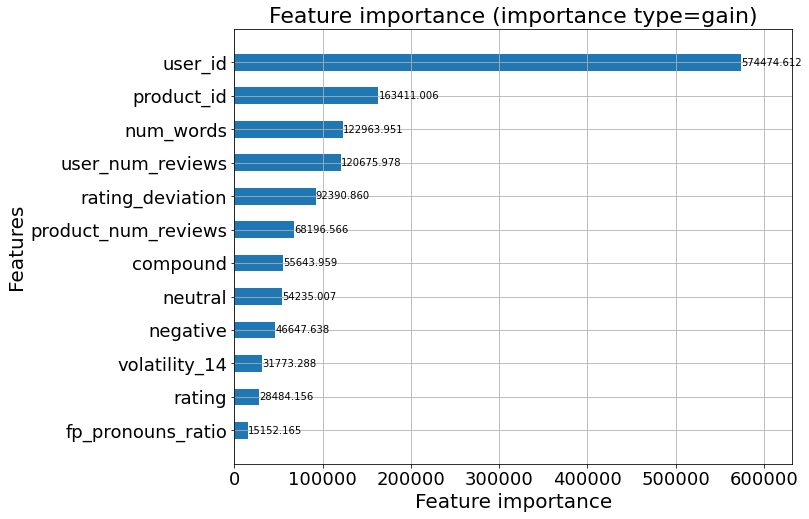

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

lgb.plot_importance(lgb_model, max_num_features=30, height=0.5, importance_type="gain", ax=ax)

plt.title("Feature importance (importance type=gain)", size=22)
plt.ylabel("Features", size=20)
plt.xlabel("Feature importance", size=20)

plt.tick_params(axis='both', which='major', labelsize=18)


## SHAP Values (SHapley Additive exPlanations)

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction.

SHAP values are proportional to the probability of being fake here.

If the SHAP values are higher, it means that target values are higher. In this dataset, it mean that it is more likely to be target = 1 (= fake).

We retrain our models with fewer dataset because running SHAP takes a lot of time.

We won't investigate user_num_reviews and product_num_reviews in SHAP because count feature needs many rows and SHAP can't deal with too many rows (it runs forever).

In [28]:
shap_total = data.sample(5000)

shap_train_y = shap_total[shap_total["date"] < TRAIN_END]["label"]
shap_train_X = shap_total[shap_total["date"] < TRAIN_END].drop(na_cols, axis=1)

shap_val_y = shap_total[shap_total["date"] >= TRAIN_END]["label"]
shap_val_X = shap_total[shap_total["date"] >= TRAIN_END].drop(na_cols, axis=1)

print("shap_train_X shape", shap_train_X.shape)
print("shap_train data ratio", shap_train_X.shape[0]/shap_total.shape[0], "\n")

print("shap_val_X shape", shap_val_X.shape)
print("shap_val data ratio", shap_val_X.shape[0]/shap_total.shape[0], "\n")


shap_train_X shape (3561, 19)
shap_train data ratio 0.7122 

shap_val_X shape (1439, 19)
shap_val data ratio 0.2878 



In [32]:
# Count feature per user_id
num_reviews =  shap_train_X.groupby(["user_id"], as_index=False)["rating"].count().rename(columns={"rating": "user_num_reviews"})

shap_train_X = shap_train_X.merge(num_reviews, how="left", on="user_id")
shap_val_X = shap_val_X.merge(num_reviews, how="left", on="user_id")


# Count feature per product id
num_reviews =  shap_train_X.groupby(["product_id"], as_index=False)["rating"].count().rename(columns={"rating": "product_num_reviews"})

shap_train_X = shap_train_X.merge(num_reviews, how="left", on="product_id")
shap_val_X = shap_val_X.merge(num_reviews, how="left", on="product_id")

shap_val_X.head(1)



,user_id,product_id,rating,volatility_3,volatility_7,volatility_14,volatility_30,volatility_60,MA_gap_1month,MA_gap_2month,num_words,num_unique_words,unique_words_ratio,fp_pronouns_ratio,rating_deviation,negative,neutral,positive,compound,user_num_reviews,product_num_reviews
0,131159,682,5.0,2.645751,1.618347,1.368805,1.028893,1.178431,7.5,7.5,32,31,0.96875,0.0625,0.145374,0.0,0.468,0.532,0.9803,NaN,NaN


In [44]:
import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

use_cols = ['user_id','product_id', 'rating','negative', 'neutral', 'compound', 'fp_pronouns_ratio', 'rating_deviation',
           'num_words','volatility_14']

lgb_train = lgb.Dataset(shap_train_X[use_cols], shap_train_y,
                        feature_name=use_cols)

lgb_eval = lgb.Dataset(shap_val_X[use_cols], shap_val_y, reference=lgb_train)


metric = 'logloss'

params = {'objective': 'binary',
#           'num_leaves': 70,
#           'min_data_in_leaf': 50,
          'max_depth': -1,
          'learning_rate':0.01,
#           metric": metric,"eval_metric": metric
		 }


shap_lgb_model = lgb.train(params= params,
                    train_set=lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    num_boost_round=10000,
                    early_stopping_rounds=100,
                    verbose_eval=10,
                    )


preds = shap_lgb_model.predict(shap_val_X[use_cols])
preds = np.where(preds > 0.5, 1, 0)


print()
print("features: ", use_cols)
print()
print("Accuracy: ", accuracy_score(preds, shap_val_y))
print("Precison: ", precision_score(preds, shap_val_y))
print("Recall:   ", recall_score(preds, shap_val_y))
print("F1 score: ", f1_score(preds, shap_val_y))

[LightGBM] [Info] Number of positive: 1719, number of negative: 1842
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 3561, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482730 -> initscore=-0.069109
[LightGBM] [Info] Start training from score -0.069109
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.667091	valid_1's binary_logloss: 0.681478
[20]	training's binary_logloss: 0.64545	valid_1's binary_logloss: 0.673248
[30]	training's binary_logloss: 0.62686	valid_1's binary_logloss: 0.666993
[40]	training's binary_logloss: 0.610688	valid_1's binary_logloss: 0.662443
[50]	training's binary_logloss: 0.596394	valid_1's binary_logloss: 0.659383
[60]	training's binary_logloss: 0.583627	valid_1's binary_logloss:

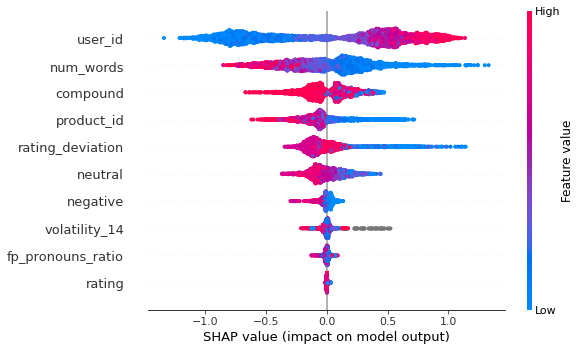

In [45]:
import shap
shap.initjs()


explainer = shap.TreeExplainer(shap_lgb_model, data=shap_train_X[use_cols], feature_dependence="tree_path_dependent")

X_tr_shap_values = explainer.shap_values(shap_train_X[use_cols])


shap.summary_plot(shap_values=X_tr_shap_values,
                  features=shap_train_X[use_cols],
                  feature_names=shap_train_X[use_cols].columns)


SHAP describes which feature affects target how much and SHAP values is proportional to the probability of being fake review.

Here the label for real review is 0 and the label for fake review is 1.

Interesting points

1. Probability of being fake review (=1) increases as the number of words gets lower. 

2. When rating deviation is very low (< 0), the probability of being fake increases. (Ex: Let’s say average rating of restaurant A is 4.0. If the rating is 1.0, the probability of being fake review is higher.)

3. When neutral feeling is low, the probability of being fake increases while it decreases when neutral feeling is high. If the user review contains extreme feelings, it is more to be fake review.

*  user_id is irrelavant here.
*  Compound is the sum of all feelings

## Tree split

Let's look at the split of the tree at booster index=0 and 1.

Tree of booster index = 0 is the very first tree that was boosted (added) to LightGBM

Text(0.5, 1.0, 'Booster index: 0')

<AxesSubplot:title={'center':'Booster index: 0'}>

Text(0.5, 1.0, 'Booster index: 1')

<AxesSubplot:title={'center':'Booster index: 1'}>

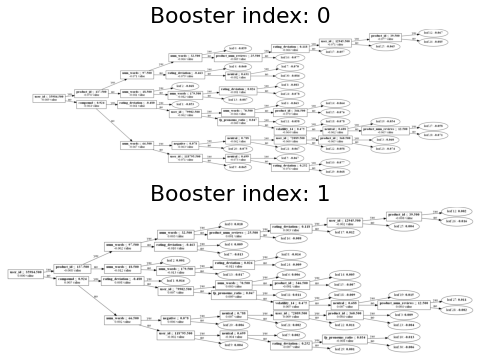

'Tree.gv.png'

In [39]:
# 先頭の決定木を可視化してみる
rows = 2
cols = 1
# 表示する領域を準備する
fig = plt.figure(figsize=(12, 6))
# 一本ずつプロットしていく
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=shap_lgb_model,
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    orientation="horizontal"
                    )
    
# fig.set_size_inches(50, 50)

plt.show()

graph = lgb.create_tree_digraph(shap_lgb_model, tree_index=1, format='png', name='Tree', show_info="split_gain")
graph.render(view=True)



Tree split is saved as Tree.gv.png.

Num_words, rating deviation, and sentimental score plays significant role.

* Value for user_id is irrelevant. Tree model is just trying to narrows down fake users using inequality signs.